In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Dataset link: https://drive.google.com/file/d/1oQP30WOBhAt6bAy1Csp3wpMgdVTJq-Xf/view?usp=sharing

In [ ]:
!unzip "/content/gdrive/MyDrive/ASL Fingerspelling dataset.zip" #zip file location

Streaming output truncated to the last 5000 lines.
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2618.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_262.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2620.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2621.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2622.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2623.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2624.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2625.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2626.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2627.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2628.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2629.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_263.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2630.jpg  
  inflating: ASL Fingerspelling dataset/Train/Y/Y_2631.jpg  
  inflating: ASL Fingerspelling data

**Method 1:**


In [ ]:
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
import random
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras.applications.mobilenet import MobileNet
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
PATH = '/content/ASL Fingerspelling dataset'
train_dir = os.path.join(PATH,'Train')
#valid_dir = os.path.join(PATH,'Dev')
test_dir = os.path.join(PATH,'Test')
test_dir

'/content/ASL Fingerspelling dataset/Test'

In [ ]:
#================================== Step 4 =================================================

# Returns class list and class-label dictionary
def get_category(pathname):
    category_list = list()
    for folder in os.listdir(pathname):
      category_list.append(folder)
    category_list = sorted(category_list)

    # dictionary to maintain numerical labels
    num_list = [number for number in range(len(category_list))]
    class_dict = dict()
    map_characters = dict()
    for i in range(len(category_list)):
        class_dict[category_list[i]] = num_list[i] 
        map_characters[num_list[i]] = category_list[i]
    
    return category_list,class_dict,map_characters
#================================== Step 5 =================================================

# Image files are resized and converted to a numpy array.
def get_data(PATH,imageSize):
    X_data = []
    y_label = []
    category_list, class_dict, map_characters = get_category(PATH)
    for folderName in category_list:
        print("Working on Folder",folderName)
        folder_path = PATH + '/' + folderName
        files = os.listdir(folder_path)
        for i in range(100):
            random.shuffle(files)
        for image_filename in files:
            image_pathname = folder_path + '/' + image_filename
            img_file = cv2.imread(image_pathname)
            if img_file is not None:
                img_file = cv2.resize(img_file, (imageSize, imageSize))
                img_arr = np.asarray(img_file)
                X_data.append(img_arr)
                y_label.append(class_dict[folderName])
            
    X_data = np.asarray(X_data)
    y_label = np.asarray(y_label)
    return X_data,y_label

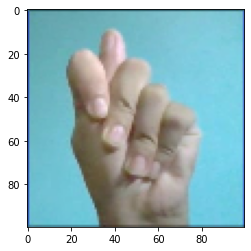

In [ ]:
img = cv2.imread(train_dir + "/T/T_90.jpg")
img_file = cv2.resize(img, (100, 100))
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB))

In [ ]:
# get_data() function callback
train_data_path = '/content/ASL Fingerspelling dataset/Train/'
X_data,y_label = get_data(PATH = train_data_path,imageSize = 100)
print("Shape of train data:",X_data.shape)
print("Shape of train labels:",y_label.shape)

Working on Folder A
Working on Folder B
Working on Folder C
Working on Folder D
Working on Folder E
Working on Folder F
Working on Folder G
Working on Folder H
Working on Folder I
Working on Folder J
Working on Folder K
Working on Folder L
Working on Folder M
Working on Folder N
Working on Folder O
Working on Folder P
Working on Folder Q
Working on Folder R
Working on Folder S
Working on Folder T
Working on Folder U
Working on Folder V
Working on Folder W
Working on Folder X
Working on Folder Y
Working on Folder Z
Working on Folder space
Shape of train data: (90200, 100, 100, 3)
Shape of train labels: (90200,)


In [ ]:
np.save('/content/gdrive/MyDrive/Colab Notebooks/x_train.npy',X_data)
print("=========== x_train.npy saved ============")
np.save('/content/gdrive/MyDrive/Colab Notebooks/y_train.npy',y_label)
print("=========== y_train.npy saved ============")

=========== x_train.npy saved ============
=========== y_train.npy saved ============


In [ ]:
test_data_path = '/content/ASL Fingerspelling dataset/Test/'
X_test, y_test = get_data(PATH = test_data_path, imageSize =100)
print("Shape of test data:",X_test.shape)
print("Shape of test labels:",y_test.shape)

Working on Folder A
Working on Folder B
Working on Folder C
Working on Folder D
Working on Folder E
Working on Folder F
Working on Folder G
Working on Folder H
Working on Folder I
Working on Folder J
Working on Folder K
Working on Folder L
Working on Folder M
Working on Folder N
Working on Folder O
Working on Folder P
Working on Folder Q
Working on Folder R
Working on Folder S
Working on Folder T
Working on Folder U
Working on Folder V
Working on Folder W
Working on Folder X
Working on Folder Y
Working on Folder Z
Working on Folder space
Shape of test data: (13500, 100, 100, 3)
Shape of test labels: (13500,)


In [ ]:
np.save('/content/gdrive/MyDrive/Colab Notebooks/x_test.npy',X_test)
print("=========== x_test.npy saved ==========")
np.save('/content/gdrive/MyDrive/Colab Notebooks/y_test.npy',y_test)
print("=========== y_test.npy saved ============")

=========== x_test.npy saved ==========
=========== y_test.npy saved ============


In [ ]:
X_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/x_train.npy')
y_train = np.load('/content/gdrive/MyDrive/Colab Notebooks/y_train.npy')
X_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/x_test.npy')
y_test = np.load('/content/gdrive/MyDrive/Colab Notebooks/y_test.npy')

In [ ]:
category_list = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space']
print(category_list)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space']


In [ ]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0...0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = len(category_list))
y_testHot = to_categorical(y_test, num_classes = len(category_list))

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_valid, labels_train, labels_valid = train_test_split(X_train, y_trainHot, test_size=0.30, random_state=42)

In [ ]:
print("Shape of X_train:", data_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_train:", labels_train.shape)
print("Shape of y_test:",y_testHot.shape)
print("Shape of x_valid:", data_valid.shape)
print("Shape of y_valid:",labels_valid.shape)

Shape of X_train: (63140, 100, 100, 3)
Shape of X_test: (13500, 100, 100, 3)
Shape of y_train: (63140, 27)
Shape of y_test: (13500, 27)
Shape of x_valid: (27060, 100, 100, 3)
Shape of y_valid: (27060, 27)


In [ ]:
IMAGE_SIZE = [100, 100]
#here [3] denotes for RGB images(3 channels)
#don’t train existing weights
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
prediction = Dense(len(category_list), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath='myCNNmodel.h5', 
                             verbose=1, 
                             save_best_only=True)
callback_list = [checkpoint]
start = datetime.now()
history = model.fit(x = data_train ,
                        y = labels_train ,
                        batch_size = 64,
                        validation_data=(data_valid,labels_valid),
                        epochs = 5, 
                        verbose=1,
                        callbacks = callback_list)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/5
987/987 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.9763
Epoch 00001: val_loss improved from inf to 0.02934, saving model to myCNNmodel.h5
987/987 [==============================] - 85s 86ms/step - loss: 0.2609 - accuracy: 0.9763 - val_loss: 0.0293 - val_accuracy: 0.9947
Epoch 2/5
986/987 [============================>.] - ETA: 0s - loss: 0.0261 - accuracy: 0.9955
Epoch 00002: val_loss did not improve from 0.02934
987/987 [==============================] - 84s 85ms/step - loss: 0.0261 - accuracy: 0.9955 - val_loss: 0.0789 - val_accuracy: 0.9918
Epoch 3/5
986/987 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9970
Epoch 00003: val_loss improved from 0.02934 to 0.01300, saving model to myCNNmodel.h5
987/987 [==============================] - 84s 85ms/step - loss: 0.0259 - accuracy: 0.9970 - val_loss: 0.0130 - val_accuracy: 0.9985
Epoch 4/5
986/987 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9986
Ep

In [ ]:
map_characters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'space'}

In [ ]:
model.load_weights("myCNNmodel.h5")

In [ ]:
score=model.evaluate(X_test)
print(score[0],score[1])

422/422 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0



              precision    recall  f1-score   support

           A       1.00      1.00      1.00       500
           B       1.00      1.00      1.00       500
           C       1.00      1.00      1.00       500
           D       0.97      1.00      0.99       500
           E       1.00      1.00      1.00       500
           F       0.96      1.00      0.98       500
           G       1.00      0.90      0.95       500
           H       1.00      1.00      1.00       500
           I       0.99      1.00      0.99       500
           J       1.00      1.00      1.00       500
           K       1.00      1.00      1.00       500
           L       1.00      1.00      1.00       500
           M       1.00      0.99      0.99       500
           N       0.99      1.00      0.99       500
           O       1.00      1.00      1.00       500
           P       1.00      1.00      1.00       500
           Q       1.00      1.00      1.00       500
           R       1.00   

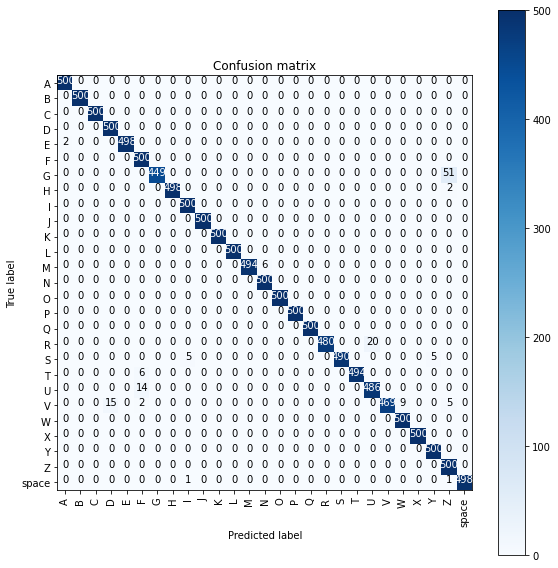

In [ ]:
labels = map_characters
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_testHot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1)
print("============================================================================================")
print("Y_pred_classes:",Y_pred_classes) 
print("============================================================================================")
Y_true = np.argmax(y_testHot,axis = 1) 
print("Y_true",Y_true)
print("============================================================================================")
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
plt.savefig('confusion_matrix.jpg',dpi=300, bbox_inches='tight')
plt.show()


**Method 2**


In [ ]:
# **Using ImageDataGenerator in keras to split data into training,validation and testing dataset**

datagen = ImageDataGenerator(rescale=1./255,validation_split=0.3)
test_datagen = ImageDataGenerator(rescale=1./255)
training_set = datagen.flow_from_directory(train_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          color_mode = 'rgb',
                                          class_mode = 'categorical',
                                          subset = "training")

validation_set = datagen.flow_from_directory(train_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            color_mode = 'rgb',
                                            class_mode = 'categorical',
                                            subset = "validation")

test_set = test_datagen.flow_from_directory(test_dir,
                                      target_size = (224, 224),
                                      batch_size = 32,
                                      color_mode = 'rgb',
                                      class_mode = 'categorical')

In [ ]:
#**Loading a pretrained VGG16 model**
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)
#labels = validation_set.class_indices
#print(labels)
predictions = Dense(27,"softmax")(x)
model = Model(inputs=vgg.input,outputs=predictions)
model.compile(loss='categorical_crossentropy', 
              optimizer= "adam", 
              metrics=['accuracy'])
model.summary()


In [ ]:
# Train the model
from datetime import datetime
from keras.callbacks import ModelCheckpoint
checkpoint1 = ModelCheckpoint(filepath='model-bestWeights_vloss.h5', 
                             verbose=1, 
                             save_best_only=True)
checkpoint2 = ModelCheckpoint(filepath='model-bestWeights_vacc.h5', 
                             monitor ='val_accuracy',
                             verbose=1, 
                             save_best_only=True)
callback_list = [checkpoint1,checkpoint2]
start = datetime.now()
history = model.fit_generator(training_set, 
                              steps_per_epoch=len(training_set), 
                              epochs = 5, 
                              verbose=1, 
                              validation_data = validation_set, 
                              validation_steps = len(validation_set),
                              callbacks= callback_list)
duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
model.load_weights('/content/model-bestWeights_vloss.h5')
score= model.evaluate(test_set)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])